In [11]:
from torchvision.io import read_image
from torchvision.transforms.functional import crop, resize, rgb_to_grayscale
from torch.utils.data import IterableDataset
import itertools
from obb_anns import OBBAnns
from pathlib import Path
import json
filepath = r"C:\Users\alexh\Desktop\ComputerVision\Hausarbeit\deepscores_v2_dense\ds2_dense\deepscores_train.json"
basePath = r"C:\Users\alexh\Desktop\ComputerVision\Hausarbeit\deepscores_v2_dense\ds2_dense\images\\" 


def to_grayscale(tensor):
    # tensor: [C, H, W] mit C=3 → gibt [1, H, W] zurück
    return rgb_to_grayscale(tensor, num_output_channels=1)

class SymbolCropStreamer(IterableDataset):
    def __init__(self,target_size=(64, 64), transform=None):
        self.data = []
        with open(filepath, 'r') as f:
            self.data = json.load(f)
            
        self.o = OBBAnns(filepath)
        self.o.load_annotations()
        self.img_index = 0
        self.ann_index = 0
        self.img , self.current_anns = self.o.get_img_ann_pair([0])
        self.current_src_img = None
        self.load_first()
        self.target_size = target_size
        self.transform = transform

    def load_first(self):
        self.img, self.current_anns = self.o.get_img_ann_pair([self.img_index])
        img_path = Path(basePath) / self.img[0]["filename"]
        self.current_src_img = read_image(img_path).float() / 255

    def load_next(self):
        self.img_index += 1
        if self.img_index >= len(self.o):
            return False
        self.ann_index = 0
        self.img, self.current_anns = self.o.get_img_ann_pair([self.img_index])
        img_path = Path(basePath) / self.img[0]["filename"]
        self.current_src_img = read_image(img_path).float() / 255
        return True
    
    def get_bounding_box_cat(self):
        bb, cat = self.current_anns[0]["a_bbox"].values[self.ann_index], self.current_anns[0]["cat_id"].values[self.ann_index]
        if cat[0] == 135:
            print("staff line")
            self.ann_index +=1
            if self.ann_index >= len(self.current_anns[0]):
                r = self.load_next()
                if not r:
                    return False
            return self.get_bounding_box_cat()
        return bb, cat
        

    

    def __iter__(self):
        while self.img_index < len(self.o):
            if self.ann_index >= len(self.current_anns[0]):
                r = self.load_next()
                if not r:
                    break
            bounding_box, cat = self.get_bounding_box_cat()#Rekursion einführen
            x, y, x1, y1 = map(int, bounding_box)
            patch = crop(self.current_src_img, top=y, left=x, height=y1 - y, width=x1 - x)
            patch = resize(patch, self.target_size)
            if self.transform:
                patch = self.transform(patch)
            self.ann_index += 1
            yield patch, cat


In [16]:
import matplotlib.pyplot as plt

def plot_img(patch, cat):
    print(f"Patch shape:", patch.shape)  # z.B. torch.Size([3, 28, 28])

    # 2) Auf [H, W, C] permuten und als NumPy holen
    img = patch.squeeze(0).cpu().numpy()

    # 3) Figure-Größe festlegen, damit das Bild nicht rein-scrollt
    plt.figure(figsize=(4, 4))
    # 4) Ganze Pixel anzeigen (interpolation='none' oder 'nearest' geht beides)
    plt.imshow(img, interpolation='nearest')
    plt.title(f"Category {cat}", fontsize=10)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [13]:
# dataloader = SymbolCropStreamer()
from torch.utils.data import DataLoader

def createDataloader():
    dataset = SymbolCropStreamer(target_size=(28, 28), transform=to_grayscale)
    dataloader = DataLoader(
        dataset,
        batch_size=32,        # z.B. 32 Patches pro Batch
        num_workers=0,        # Anzahl Worker‐Prozesse (je nach CPU-Kernen anpassen)
        pin_memory=True       # bei GPU-Training oft sinnvoll
    )
    return dataloader

dataloader = createDataloader()

print(type(dataloader))  

loading ann_info...
done! t=4.96s
<class 'torch.utils.data.dataloader.DataLoader'>


<class 'torch.Tensor'>
<class 'list'>
Patch shape: torch.Size([1, 28, 28])


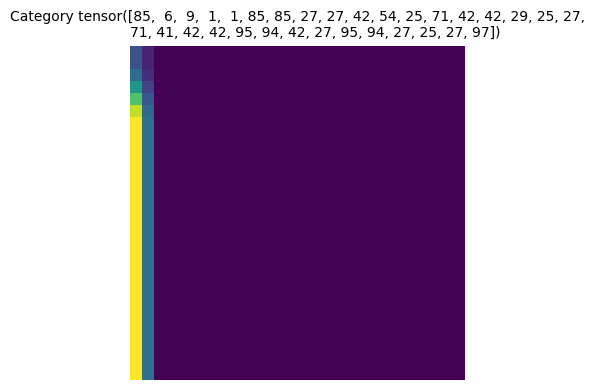

Patch shape: torch.Size([1, 28, 28])


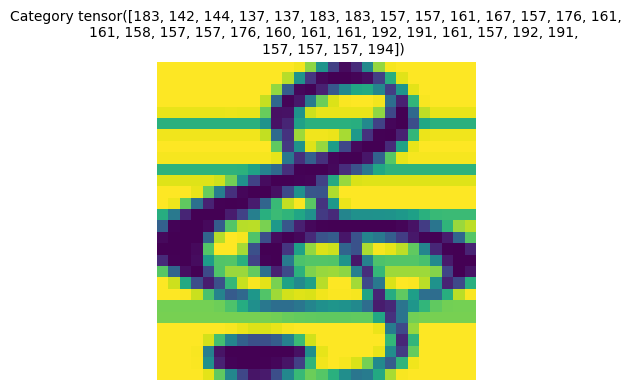

staff line
staff line
<class 'torch.Tensor'>
<class 'list'>


In [17]:
for n, (batch_patches, batch_cats) in  enumerate(dataloader):
    print(type(batch_patches))
    print(type(batch_cats))
    if(n >= 1):
        break
    for i in range(len(batch_cats)):
        plot_img(batch_patches[i], batch_cats[i])

loading ann_info...
done! t=6.58s
[135, 208] <class 'int'>
staff line
[2, 138] <class 'int'>
Patch 0 shape: torch.Size([3, 3, 30])


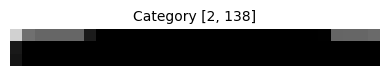

[2, 138] <class 'int'>
Patch 1 shape: torch.Size([3, 3, 31])


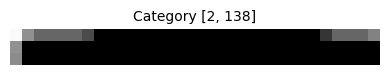

[2, 138] <class 'int'>
Patch 2 shape: torch.Size([3, 3, 30])


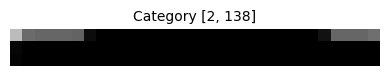

[2, 138] <class 'int'>
Patch 3 shape: torch.Size([3, 3, 31])


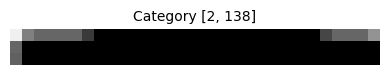

[2, 138] <class 'int'>
Patch 4 shape: torch.Size([3, 3, 30])


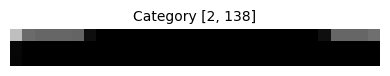

[2, 138] <class 'int'>
Patch 5 shape: torch.Size([3, 3, 31])


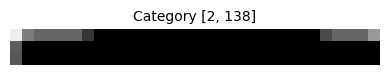

[2, 138] <class 'int'>
Patch 6 shape: torch.Size([3, 2, 44])


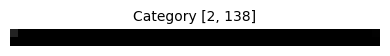

[2, 138] <class 'int'>
Patch 7 shape: torch.Size([3, 3, 44])


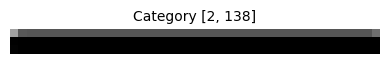

[2, 138] <class 'int'>
Patch 8 shape: torch.Size([3, 2, 44])


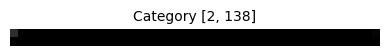

[2, 138] <class 'int'>
Patch 9 shape: torch.Size([3, 3, 44])


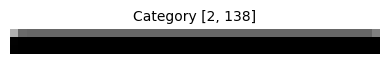

[2, 138] <class 'int'>


In [5]:
import matplotlib.pyplot as plt

dataloader = SymbolCropStreamer()

def plot_img(patch, cat):
    print(f"Patch {n} shape:", patch.shape)  # z.B. torch.Size([3, 28, 28])

    # 2) Auf [H, W, C] permuten und als NumPy holen
    img = patch.permute(1, 2, 0).cpu().numpy()

    # 3) Figure-Größe festlegen, damit das Bild nicht rein-scrollt
    plt.figure(figsize=(4, 4))
    # 4) Ganze Pixel anzeigen (interpolation='none' oder 'nearest' geht beides)
    plt.imshow(img, interpolation='nearest')
    plt.title(f"Category {cat}", fontsize=10)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


for n, (patch, cat) in enumerate(dataloader):
    if n >= 10:
        break
    # 1) Form prüfen (sollte [C, H, W] sein)
    plot_img(patch, cat)